# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# [1]. Reading Data

In [2]:
# using the SQL Table to read data.
import mysql.connector
con=mysql.connector.connect(
    host="localhost",
    user="root",
    passwd="Mother9922*",
    database='data1'
    )

#con=sqlite3.connect(r"/content/drive/My Drive/APPLIED_AI_COURSE/ALL_AI_COURSE_CODE/AMAZON FOOD REVIEWS ANALYSIS/database.sqlite")


#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 10000""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (10000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId   
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80667, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,ABXLMWJIXXAIN,B000LQOCH0,"Natalia Corres ""Natalia Corres""",1219017600,4,This is a confection that has been around a fe...,3
1,A395BORC6FGVXV,B000UA0QIQ,Karl,1307923200,2,If you are looking for the secret ingredient i...,3
2,A1UQRSCLF8GW1T,B006K2ZZ7K,"Michael D. Bigham ""M. Wassir""",1350777600,5,Great taffy at a great price. There was a wid...,2
3,A1SP2KVKFXXRU1,B006K2ZZ7K,David C. Sullivan,1340150400,5,This saltwater taffy had great flavors and was...,2
4,A1MZYO9TZK0BBI,B000E7L2R4,R. James,1322006400,5,Right now I'm mostly just sprouting this so my...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
18816,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


#  Exploratory Data Analysis

## [2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [6]:
display= pd.read_sql_query("""
SELECT * FROM Reviews WHERE Score != 3 AND UserId="AR5J8UI46CURR" 
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [7]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [8]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(9564, 10)

In [9]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

95.64

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [11]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [12]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(9564, 10)


1    7976
0    1588
Name: Score, dtype: int64

# [3].  Text Preprocessing:Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [13]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

262-TRIAL-Got a free package of these with a bottle of bloody mary mix I bought from the seller, and the advertising worked..lol,  I tried them, and shared them with 2 buddies, and we all loved them...  So im here to buy more, and noticed there were no reviews yet,...  well now there is.  They are Hot,  but not "burn your mouth forever hot"  its a nice temp...  Perfect for us.. 164
This is a very good snack that I feel great about offering my 10 month old.  She can easily  pick up the small pieces and definitely enjoys the apple cinnamon taste.  My 5 year old loves them as well!  I would definitely recommend these to anyone with small (or larger) kids.  :)
These spicy chips have a lot of great flavor but be warned, you will be left with some stanky breath afterwards! The first time I ate these was at night and then even after brushing and flossing I could taste them in my mouth the next morning. So just be careful about when you eat them, especially if you will be hanging out with peop

In [14]:
#finding sentences containing html tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

2
Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [15]:
# remove urls from text python: 
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

262-TRIAL-Got a free package of these with a bottle of bloody mary mix I bought from the seller, and the advertising worked..lol,  I tried them, and shared them with 2 buddies, and we all loved them...  So im here to buy more, and noticed there were no reviews yet,...  well now there is.  They are Hot,  but not "burn your mouth forever hot"  its a nice temp...  Perfect for us.. 164


In [16]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

262-TRIAL-Got a free package of these with a bottle of bloody mary mix I bought from the seller, and the advertising worked..lol,  I tried them, and shared them with 2 buddies, and we all loved them...  So im here to buy more, and noticed there were no reviews yet,...  well now there is.  They are Hot,  but not "burn your mouth forever hot"  its a nice temp...  Perfect for us.. 164
This is a very good snack that I feel great about offering my 10 month old.  She can easily  pick up the small pieces and definitely enjoys the apple cinnamon taste.  My 5 year old loves them as well!  I would definitely recommend these to anyone with small (or larger) kids.  :)
These spicy chips have a lot of great flavor but be warned, you will be left with some stanky breath afterwards! The first time I ate these was at night and then even after brushing and flossing I could taste them in my mouth the next morning. So just be careful about when you eat them, especially if you will be hanging out with peop

In [17]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

These spicy chips have a lot of great flavor but be warned, you will be left with some stanky breath afterwards! The first time I ate these was at night and then even after brushing and flossing I could taste them in my mouth the next morning. So just be careful about when you eat them, especially if you will be hanging out with people later in the day.


In [19]:
#remove words with numbers python:
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

a free package of these with a bottle of bloody mary mix I bought from the seller, and the advertising worked..lol,  I tried them, and shared them with  buddies, and we all loved them...  So im here to buy more, and noticed there were no reviews yet,...  well now there is.  They are Hot,  but not "burn your mouth forever hot"  its a nice temp...  Perfect for us..


In [20]:
#remove spacial character: 
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

These spicy chips have a lot of great flavor but be warned you will be left with some stanky breath afterwards The first time I ate these was at night and then even after brushing and flossing I could taste them in my mouth the next morning So just be careful about when you eat them especially if you will be hanging out with people later in the day 


In [21]:
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)  #removing weblink
    sentance = BeautifulSoup(sentance, 'lxml').get_text()#remove html tags
    sentance = decontracted(sentance)                  #expanding the word
    sentance = re.sub("\S*\d\S*", "", sentance).strip() #removing words with numbers
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)      #removing special characters
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords) #removing the stopwords
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 9564/9564 [00:03<00:00, 3163.82it/s]


In [23]:
preprocessed_reviews[1500]

'spicy chips lot great flavor warned left stanky breath afterwards first time ate night even brushing flossing could taste mouth next morning careful eat especially hanging people later day'

In [24]:
final.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaaa', 'aahhhs', 'ab', 'aback', 'abandon', 'abates', 'abberline', 'abbott', 'abby']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (9564, 18244)
the number of unique words  18244


## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram
#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation
# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (9564, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able eat', 'able find', 'able get', 'able order', 'able use', 'absolute', 'absolute best']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (9564, 5765)
the number of unique words including both unigrams and bigrams  5765


## [4.4] Word2Vec

In [28]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [29]:
# Using Google News Word2Vectors
# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# it's 1.9GB in size.
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=True
want_to_use_google_w2v = True
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('good', 0.9045876860618591), ('excellent', 0.8915691375732422), ('well', 0.7907481789588928), ('wonderful', 0.7906196117401123), ('quick', 0.7881029844284058), ('speedy', 0.7828683853149414), ('overall', 0.7754072546958923), ('presentation', 0.7716149687767029), ('value', 0.7654623985290527), ('makes', 0.7641398310661316)]
[('absolute', 0.9926565885543823), ('hands', 0.9886135458946228), ('addicted', 0.9878953695297241), ('disappointing', 0.9871962666511536), ('wins', 0.9870612621307373), ('grey', 0.9852493405342102), ('stephen', 0.9852421879768372), ('varieties', 0.9839009642601013), ('choices', 0.9836229085922241), ('sweetest', 0.9834455847740173)]


In [30]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  5652
sample words  ['free', 'package', 'bottle', 'bloody', 'mary', 'mix', 'bought', 'seller', 'advertising', 'worked', 'lol', 'tried', 'shared', 'buddies', 'loved', 'im', 'buy', 'noticed', 'no', 'reviews', 'yet', 'well', 'hot', 'not', 'burn', 'mouth', 'forever', 'nice', 'temp', 'perfect', 'us', 'used', 'fly', 'bait', 'seasons', 'ca', 'beat', 'great', 'product', 'available', 'traps', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'received', 'shipment', 'could']


## [4.4.1] Converting text into vectors using wAvg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [31]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 9564/9564 [00:11<00:00, 855.37it/s]

9564
50


#### [4.4.1.2] TFIDF weighted W2v

In [32]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [33]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 9564/9564 [01:16<00:00, 125.38it/s]


# [5] Applying TSNE

<ol> 
    <li> you need to plot 4 tsne plots with each of these feature set
        <ol>
            <li>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ol>
    </li>
    <li> <font color='blue'>Note 1: The TSNE accepts only dense matrices</font></li>
    <li> <font color='blue'>Note 2: Consider only 5k to 6k data points </font></li>
</ol>

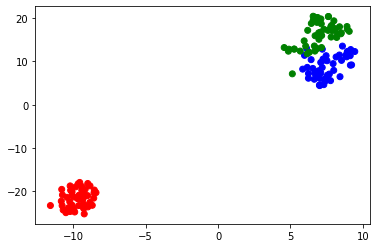

In [34]:
# https://github.com/pavlin-policar/fastTSNE you can try this also, this version is little faster than sklearn 
import numpy as np
from sklearn.manifold import TSNE
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt

iris = datasets.load_iris()
x = iris['data']
y = iris['target']

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)

X_embedding = tsne.fit_transform(x)
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.toarray()) , .toarray() will convert the sparse matrix into dense matrix

for_tsne = np.hstack((X_embedding, y.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
colors = {0:'red', 1:'blue', 2:'green'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.show()

## [5.1] Applying TNSE on Text BOW vectors

In [35]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

In [36]:
#importing tsne
from sklearn.manifold import TSNE
final_counts_subset=final_counts[:2000,:]## because t-sne will take quite long on my machine to train

In [37]:
final_counts.shape

(9564, 18244)

In [38]:
final_counts_subset.shape

(2000, 7436)

In [39]:
tsne=TSNE(n_components=2,random_state=0,perplexity=50)
#we can apply tsne only on dense vector
dim_reduced_bow=tsne.fit_transform(final_counts_subset.todense())

In [40]:
type(dim_reduced_bow)

numpy.ndarray

In [41]:
labels_2000=final['Score'].head(2000)
type(labels_2000)

pandas.core.series.Series

In [42]:
labels_2000=np.array(labels_2000)
labels_2000=labels_2000.reshape(2000,1)

In [43]:
dim_reduced_bow_with_labels=np.concatenate((dim_reduced_bow,labels_2000),axis=1)

In [44]:
dim_reduced_bow_with_labels_df=pd.DataFrame(dim_reduced_bow_with_labels,columns=('Dim1','Dim2','Label'))

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt 

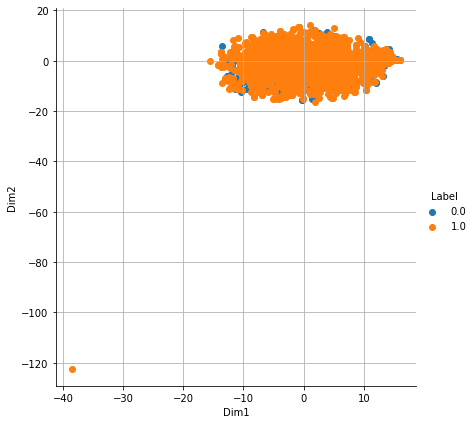

In [46]:
sns.FacetGrid(dim_reduced_bow_with_labels_df, hue = 'Label', size = 6)\
    .map(plt.scatter, 'Dim1', 'Dim2')\
    .add_legend()
plt.grid()
plt.show()

## [5.1] Applying TNSE on Text TFIDF vectors

In [47]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

In [48]:
from sklearn.manifold import TSNE

In [49]:
print(final_tf_idf.shape)
print(final_tf_idf[0])

(9564, 5765)
  (0, 5746)	0.1825268447677918
  (0, 5653)	0.20597728800239445
  (0, 5558)	0.12402259315084149
  (0, 5379)	0.17561972587631774
  (0, 5272)	0.1198095812856165
  (0, 4515)	0.24477875712158137
  (0, 4465)	0.21525624877306904
  (0, 4279)	0.1707682368439699
  (0, 3760)	0.15005204505446432
  (0, 3675)	0.17192480181531652
  (0, 3489)	0.2092859327913838
  (0, 3310)	0.06281010713526561
  (0, 3268)	0.11225608194110002
  (0, 3260)	0.14527292610633932
  (0, 3157)	0.18728182484532815
  (0, 3114)	0.1444355553455513
  (0, 2897)	0.16976866239467875
  (0, 2833)	0.25142485368459017
  (0, 2431)	0.25821129617353517
  (0, 2385)	0.2915445452793926
  (0, 2380)	0.28158275373520536
  (0, 1881)	0.1439291915722569
  (0, 1857)	0.2535563186117654
  (0, 611)	0.12038384166336243
  (0, 601)	0.24477875712158137
  (0, 514)	0.1354961518483155
  (0, 507)	0.19502214189186187


In [50]:
final_tf_idf_subset=final_tf_idf[:2000,:]

In [51]:
tsne=TSNE(n_components=2,random_state=0,perplexity=50)

In [52]:
dim_reduced_tfidf=tsne.fit_transform(final_tf_idf_subset.todense())

In [53]:
print(type(dim_reduced_tfidf))
dim_reduced_tfidf.shape

<class 'numpy.ndarray'>


(2000, 2)

In [54]:
labels_2000=final['Score'].head(2000)

In [55]:
type(labels_2000)

pandas.core.series.Series

In [56]:
labels_2000=np.array(labels_2000)

In [57]:
labels_2000.shape

(2000,)

In [58]:
labels_2000=labels_2000.reshape(2000,1)

In [59]:
dim_reduced_tfidf_with_labels=np.concatenate((dim_reduced_tfidf,labels_2000),axis=1)

In [60]:
dim_reduced_tfidf_with_labels_df=pd.DataFrame(dim_reduced_tfidf_with_labels,columns=('Dim1','Dim2','Label'))

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt 

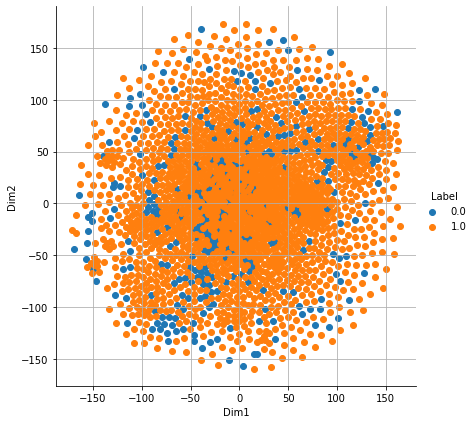

In [62]:
sns.FacetGrid(dim_reduced_tfidf_with_labels_df, hue = 'Label', size = 6)\
    .map(plt.scatter, 'Dim1', 'Dim2')\
    .add_legend()
plt.grid()
plt.show()

## [5.3] Applying TNSE on Text Avg W2V vectors

In [63]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

In [64]:
len(sent_vectors)

9564

In [65]:
from sklearn.manifold import TSNE
sent_vectors_subset=sent_vectors[:2000]

In [66]:
len(sent_vectors_subset)

2000

In [67]:
sent_vectors_subset[0]

array([-0.15481957,  0.53079515, -0.37681081,  0.30351876, -0.10455334,
       -0.05310688, -0.59572542, -0.2342729 , -0.0222652 ,  0.46949228,
       -0.29284717,  0.36492393, -0.28186398, -0.01850265, -0.3716309 ,
       -0.03259457, -0.14184295, -0.15108534, -0.0391834 , -0.30848295,
       -0.45084023,  0.22174504, -0.43489921, -0.16407   ,  0.44689827,
        0.17647238, -0.02130081,  0.44300143,  0.32352721, -0.16500093,
        0.22205824, -0.14988381, -0.23935814,  0.626402  , -0.09869909,
        0.00723837, -0.27431987,  0.49843846,  0.357077  ,  0.82842148,
       -0.29718635, -0.02415141, -0.44723321,  0.03510433, -0.46586348,
       -0.32915434, -0.10145125,  0.42795553,  0.16711528,  0.0160963 ])

In [68]:
tsne=TSNE(n_components=2,random_state=0,perplexity=50)

In [69]:
dim_reduced_avg_W2v=tsne.fit_transform(sent_vectors_subset)

In [70]:
type(dim_reduced_avg_W2v)

numpy.ndarray

In [71]:
labels_2000=final['Score'].head(2000)

In [72]:
type(labels_2000)

pandas.core.series.Series

In [73]:
labels_2000=np.array(labels_2000)

In [74]:
labels_2000 = labels_2000.reshape(2000,1)

In [75]:
dim_reduced_avg_W2v_with_labels=np.concatenate((dim_reduced_avg_W2v,labels_2000),axis=1)

In [76]:
dim_reduced_avg_W2v_with_labels_df=pd.DataFrame(dim_reduced_avg_W2v_with_labels,columns=('Dim1','Dim2','Label'))

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt 

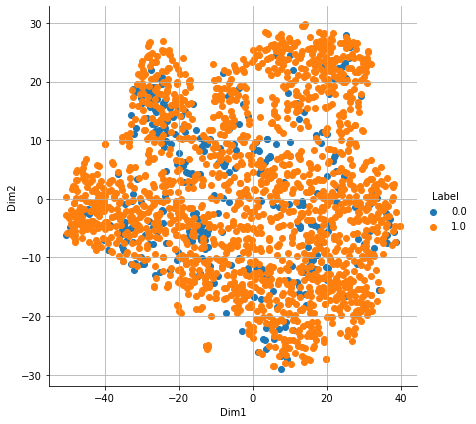

In [78]:
sns.FacetGrid(dim_reduced_avg_W2v_with_labels_df, hue = 'Label', size = 6)\
    .map(plt.scatter, 'Dim1', 'Dim2')\
    .add_legend()
plt.grid()
plt.show()

## [5.4] Applying TNSE on Text TFIDF weighted W2V vectors

In [ ]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

In [81]:
len(tfidf_sent_vectors)

9564

In [82]:
from sklearn.manifold import TSNE
tfidf_sent_vectors_subset=tfidf_sent_vectors[:2000]

In [84]:
len(tfidf_sent_vectors_subset)

2000

In [87]:
tsne=TSNE(n_components=2,random_state=0,perplexity=50)
dim_reduced_tfidf_sent_vectors=tsne.fit_transform(tfidf_sent_vectors_subset)

In [93]:
dim_reduced_tfidf_sent_vectors.shape

(2000, 2)

In [88]:
type(dim_reduced_tfidf_sent_vectors)

numpy.ndarray

In [89]:
labels_2000=final['Score'].head(2000)

In [90]:
type(labels_2000)

pandas.core.series.Series

In [91]:
labels_2000=np.array(labels_2000)

In [92]:
labels_2000=labels_2000.reshape(2000,1)

In [94]:
dim_reduced_tfidf_sent_vectors_with_labels=np.concatenate((dim_reduced_tfidf_sent_vectors,labels_2000),axis=1)

In [95]:
dim_reduced_tfidf_sent_vectors_with_labels_df=pd.DataFrame(dim_reduced_tfidf_sent_vectors_with_labels,columns=('Dim1','Dim2','Label'))

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt 

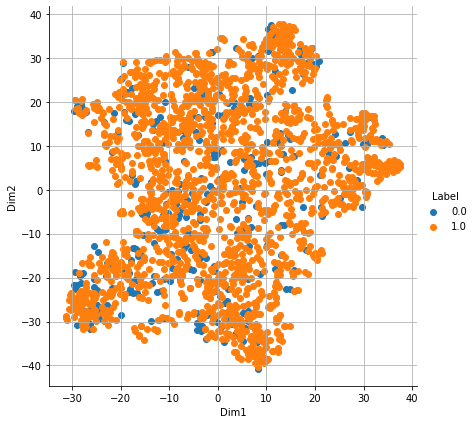

In [97]:
sns.FacetGrid(dim_reduced_tfidf_sent_vectors_with_labels_df, hue = 'Label', size = 6)\
    .map(plt.scatter, 'Dim1', 'Dim2')\
    .add_legend()
plt.grid()
plt.show()

# [6] Conclusions

we can easily observe that from bow to weighted tfidf w2v we can easily visualize the graph of weighted tfidf w2v as compared to bow